# Predicting Telecom Customer Churn

The Telecom Customer Churn dataset contains 100 different variables and 100.000 records. The response variable here is churn which explains whether the customer will churn or not.  

Using the available data, I'll develop and train a machine learning model to predict whether a customer is likely to churn or not. I'll be using data from the past, including customers that already have churned (response) and their characteristics / behaviour (predictors) before the churn happened. This method belongs to the supervised learning category.

## Methodology:  

**1. Exploratory analysis:** Randomly picked several variables to do exploratory analysis realted to the response variable (churn).


**2. Data Preparation:**  
- High correlated continuous variables
- Types of variables: categorical, continuos and discrete variables.
- Missing values: missing data was replaced with substituted values.
- Encoding: Label encoding for binary columns and one hot encoding for categorical variables with more than 2 values
- Standardization:  of datasets is a common requirement for many machine learning estimators implemented in scikit-learn; they might behave badly if the individual features do not more or less look like standard normally distributed data: Gaussian with zero mean and unit variance.  

**3. Building a Predicitive Model:** Three different models were train to predict customer churn:

- Logistic Regression
- Random Forest Classifier
- XGBoost

**4. Dimensionality Reduction:** for reducing the number of variables under consideration by obtaining a set of principal variables.

In [2]:
# importing modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import scipy.stats as stats
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
%matplotlib inline

In [3]:
# load dataset
data = pd.read_csv('Telecom_customer churn.csv')
# lowercase all columns name 
data.columns = map(str.lower, data.columns)
# fill na with np.nan
data = data.fillna(np.nan)
print(data.shape)
data.head()

(100000, 100)


,rev_mean,mou_mean,totmrc_mean,da_mean,ovrmou_mean,ovrrev_mean,vceovr_mean,datovr_mean,roam_mean,change_mou,...,forgntvl,ethnic,kid0_2,kid3_5,kid6_10,kid11_15,kid16_17,creditcd,eqpdays,customer_id
0,23.9975,219.25,22.500,0.2475,0.00,0.0,0.0,0.0,0.0,-157.25,...,0.0,N,U,U,U,U,U,Y,361.0,1000001
1,57.4925,482.75,37.425,0.2475,22.75,9.1,9.1,0.0,0.0,532.25,...,0.0,Z,U,U,U,U,U,Y,240.0,1000002
2,16.9900,10.25,16.990,0.0000,0.00,0.0,0.0,0.0,0.0,-4.25,...,0.0,N,U,Y,U,U,U,Y,1504.0,1000003
3,38.0000,7.50,38.000,0.0000,0.00,0.0,0.0,0.0,0.0,-1.50,...,0.0,U,Y,U,U,U,U,Y,1812.0,1000004
4,55.2300,570.50,71.980,0.0000,0.00,0.0,0.0,0.0,0.0,38.50,...,0.0,I,U,U,U,U,U,Y,434.0,1000005


# 1. Exploratory analysis

- The dataset is balanced, oversampling won't be performed
- Churn is higher in new cell users
- By marital status, the biggest churn rate occurs in status 'U', followed by 'M' and 'S'. Assuming that 'U' is unknown, married people tend to leave the company more frequently than single people.
- Churn by total calls, is higher in people with less calls as expected: people who doesn't use the service is more likely to leave the company.

In [4]:
# create a function to easily plot figures
def barplot(index, column, title):
    pd.crosstab(index,column).plot(kind='bar', stacked=True, rot=0, alpha=0.5, align='center', width=0.7)
    # remove all the ticks (both axes)
    plt.tick_params(top=False, bottom=False, left=True, right=False, labelleft=True, labelbottom=True)
    # remove the frame of the chart
    for spine in plt.gca().spines.values():
        spine.set_visible(False)
    plt.title(title)
    plt.show()

In [5]:
# checking the churn distribution
data['churn'].value_counts()

0    50438
1    49562
Name: churn, dtype: int64

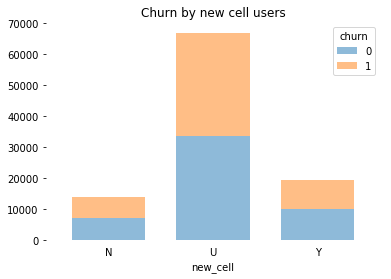

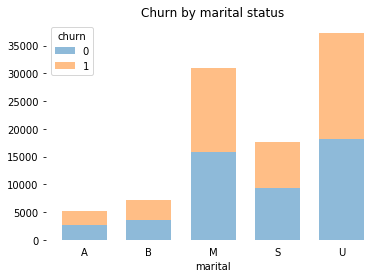

In [153]:
barplot(data['new_cell'], data['churn'], 'Churn by new cell users')
barplot(data['marital'], data['churn'], 'Churn by marital status')

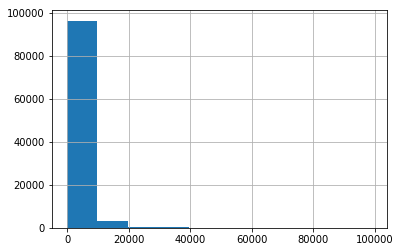

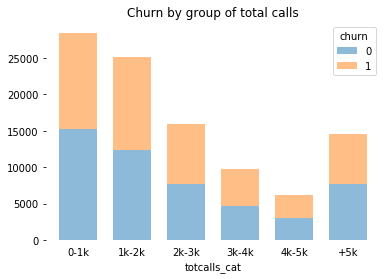

In [154]:
data['totcalls'].hist()
data_expl = data.copy()
data_expl['totcalls_cat'] = pd.cut(data['totcalls'], bins=[0, 1000, 2000, 3000, 4000, 5000, np.inf], 
                               labels=['0-1k', '1k-2k', '2k-3k', '3k-4k', '4k-5k', '+5k'])
barplot(data_expl['totcalls_cat'], data['churn'], 'Churn by group of total calls')

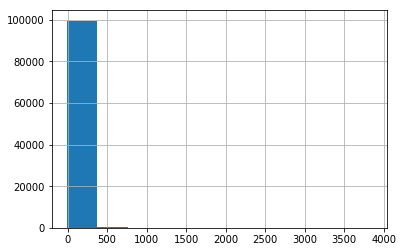

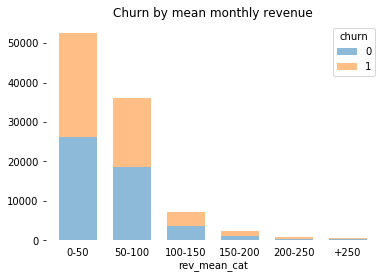

In [155]:
data['rev_mean'].hist()
data_expl['rev_mean_cat'] = pd.cut(data['rev_mean'], bins=[0, 50, 100, 150, 200, 250, np.inf], 
                               labels=['0-50', '50-100', '100-150', '150-200', '200-250', '+250'])
barplot(data_expl['rev_mean_cat'], data['churn'], 'Churn by mean monthly revenue')

# 2. Data Preparation

#### Correlation

Variables with high correlation (>0.8) will be deleted from the data set, to improve machine learning model performance.

In [156]:
num_columns = list(data.select_dtypes(include=['int64','float64']).columns)  
num_data = data[num_columns].drop(['customer_id', 'churn'],axis=1)
num_data.shape

(100000, 77)

In [157]:
correlated_features = set()  
correlation_matrix = num_data.corr() 

for i in range(len(correlation_matrix.columns)):  
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.8:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)

print('There are:', len(correlated_features), 'highly correlated features.')
print('\n')
print(correlated_features)

There are: 36 highly correlated features.


{'peak_dat_mean', 'mou_cvce_mean', 'adjqty', 'adjmou', 'owylis_vce_mean', 'opk_dat_mean', 'comp_dat_mean', 'plcd_vce_mean', 'vceovr_mean', 'avg6mou', 'mou_rvce_mean', 'adjrev', 'avg6qty', 'complete_mean', 'attempt_mean', 'models', 'comp_vce_mean', 'avg3mou', 'avg3rev', 'drop_blk_mean', 'mouowylisv_mean', 'inonemin_mean', 'totmou', 'mou_peav_mean', 'cc_mou_mean', 'mou_opkv_mean', 'peak_vce_mean', 'avg3qty', 'mou_opkd_mean', 'ccrndmou_mean', 'avgqty', 'ovrrev_mean', 'totrev', 'opk_vce_mean', 'avgmou', 'avg6rev'}


In [158]:
# new df shape after dropping correlated features
data.drop(correlated_features, axis=1, inplace=True)
data.shape

(100000, 64)

#### Types of variables

In [159]:
# find numerical variables
numerical = list(data.drop(['customer_id', 'churn'], axis=1).select_dtypes(include=['float64', 'int64']))
print('There are {} numerical variables'.format(len(numerical)))

There are 41 numerical variables


In [160]:
# let's visualise the values of the discrete variables
discrete = []
for var in numerical:
    if len(data[var].unique())<18 and var not in ['customer_id', 'churn']:
        print(var,':', data[var].unique())
        discrete.append(var)

uniqsubs : [  2   1   3   5   4   6   7   9   8  12  11  10  13  18 196]
actvsubs : [ 1  2  3  4  0  5  6  7  8  9 53 11]
truck : [ 0.  1. nan]
rv : [ 0.  1. nan]
lor : [15.  1.  7.  6.  5.  8.  0.  3.  4. 11. 10. 13. nan  2. 14. 12.  9.]
adults : [ 1.  2.  4.  3.  5. nan  6.]
income : [ 4.  5.  6.  9.  1.  7.  3. nan  8.  2.]
numbcars : [ 3.  1.  2. nan]
forgntvl : [ 0.  1. nan]


We'll have to change the dtypes of the following variables to object: forgntvl, rv and truck

In [161]:
# changing their dtype
to_object = ['forgntvl', 'rv', 'truck']

for var in to_object:
    data[var] = data[var].astype('object')

In [162]:
# categorical variables
categorical = list(data.select_dtypes(include='object'))
print('There are {} categorical variables'.format(len(categorical)))

There are 24 categorical variables


#### Missing values

In [163]:
# checking for missing values
data.isnull().sum()

rev_mean              357
mou_mean              357
totmrc_mean           357
da_mean               357
ovrmou_mean           357
datovr_mean           357
roam_mean             357
change_mou            891
change_rev            891
drop_vce_mean           0
drop_dat_mean           0
blck_vce_mean           0
blck_dat_mean           0
unan_vce_mean           0
unan_dat_mean           0
plcd_dat_mean           0
recv_vce_mean           0
recv_sms_mean           0
custcare_mean           0
threeway_mean           0
mou_cdat_mean           0
iwylis_vce_mean         0
mouiwylisv_mean         0
mou_pead_mean           0
callfwdv_mean           0
callwait_mean           0
churn                   0
months                  0
uniqsubs                0
actvsubs                0
                    ...  
avgrev                  0
prizm_social_one     7388
area                   40
dualband                1
refurb_new              1
hnd_price             847
phones                  1
hnd_webcap  

There are a several variables that contain missing information (NaN).

In [164]:
# variables with more than 20% of missing information
for var in data.columns:
    if data[var].isnull().mean()>0.20:
        print(var, data[var].unique())

ownrent ['O' nan 'R']
lor [15.  1.  7.  6.  5.  8.  0.  3.  4. 11. 10. 13. nan  2. 14. 12.  9.]
dwlltype ['S' 'M' nan]
adults [ 1.  2.  4.  3.  5. nan  6.]
infobase ['M' nan 'N']
income [ 4.  5.  6.  9.  1.  7.  3. nan  8.  2.]
numbcars [ 3.  1.  2. nan]
hhstatin ['C' 'I' nan 'B' 'A' 'G' 'H']
dwllsize ['A' 'D' 'O' nan 'E' 'J' 'C' 'B' 'I' 'N' 'K' 'L' 'G' 'H' 'M' 'F']


The ones with more than 20% of missing data are categorical and discrete variables.

In [165]:
# for discrete and categorical variables impute the mode
for col in discrete:
    data.loc[data[col].isnull() > 0, col] = data[col].mode().to_numpy()
    
for col in categorical:
    data.loc[data[col].isnull() > 0, col] = data[col].mode().to_numpy()

In [166]:
# first we make a list of continuous variables (from the numerical ones)
continuous = [var for var in numerical if var not in discrete and var not in ['customer_id', 'churn']]

# for continuous variables impute the mean
for col in continuous:
    data.loc[data[col].isnull() > 0, col] = data[col].mean()

In [167]:
# checking for missing values
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 64 columns):
rev_mean            100000 non-null float64
mou_mean            100000 non-null float64
totmrc_mean         100000 non-null float64
da_mean             100000 non-null float64
ovrmou_mean         100000 non-null float64
datovr_mean         100000 non-null float64
roam_mean           100000 non-null float64
change_mou          100000 non-null float64
change_rev          100000 non-null float64
drop_vce_mean       100000 non-null float64
drop_dat_mean       100000 non-null float64
blck_vce_mean       100000 non-null float64
blck_dat_mean       100000 non-null float64
unan_vce_mean       100000 non-null float64
unan_dat_mean       100000 non-null float64
plcd_dat_mean       100000 non-null float64
recv_vce_mean       100000 non-null float64
recv_sms_mean       100000 non-null float64
custcare_mean       100000 non-null float64
threeway_mean       100000 non-null float64
mou_cdat_m

#### Encoding

In [168]:
# binary columns with 2 values
bin_cols = data.drop(['churn', 'customer_id'], axis=1).nunique()[data.nunique() == 2].keys().tolist()
# columns with more than 2 values
multi_cols = [i for i in categorical if i not in bin_cols]

In [169]:
# label encoding Binary columns
le = LabelEncoder()
for i in bin_cols:
    data[i] = le.fit_transform(data[i])
    
# one hot encoding categorical variables with more than 2 values
data = pd.get_dummies(data=data,columns=multi_cols)
data.shape

(100000, 185)

#### Standarization

In [170]:
# scaling numerical columns
scaler = StandardScaler()
scaled = scaler.fit_transform(data[numerical].astype(np.float))
scaled = pd.DataFrame(scaled,columns=numerical)

In [171]:
# dropping original values merging scaled values for numerical columns
data_og = data.copy()
data = data.drop(columns=numerical,axis = 1)
data = data.merge(scaled,left_index=True,right_index=True,how ="left")
data.shape

(100000, 185)

# 3. Building a Predicitive Model

In [172]:
# create X and y
X = data.drop(['churn', 'customer_id'], axis=1)
y = data['churn'].values

# split dataframe into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Three different models were train to predict customer churn:

- Logistic Regression
- Random Forest Classifier
- XGBoost

#### 3.1. Logistic Regression

In [194]:
log_reg = LogisticRegression(solver='liblinear')
log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_test)
print(metrics.classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.59      0.59      0.59     15118
           1       0.58      0.59      0.58     14882

   micro avg       0.59      0.59      0.59     30000
   macro avg       0.59      0.59      0.59     30000
weighted avg       0.59      0.59      0.59     30000



#### 3.2. Random Forest Classifier

In [195]:
clf = RandomForestClassifier(n_estimators=100, n_jobs=-1)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(metrics.classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.62      0.62      0.62     15192
           1       0.61      0.62      0.61     14808

   micro avg       0.62      0.62      0.62     30000
   macro avg       0.62      0.62      0.62     30000
weighted avg       0.62      0.62      0.62     30000



#### 3.3. XGBoost

In [198]:
import xgboost as xgb

xgb_model = xgb.XGBClassifier(n_estimators=236, objective="binary:logistic", random_state=42)
xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)

0.6348333333333334

In [199]:
print(metrics.classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.63      0.64      0.63     14766
           1       0.64      0.63      0.64     15234

   micro avg       0.63      0.63      0.63     30000
   macro avg       0.63      0.63      0.63     30000
weighted avg       0.63      0.63      0.63     30000



The best performance is achieved by XGBoost, with 0.63 accuracy score.

# 4. Dimensionality Reduction

In [200]:
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

pipeline = Pipeline([
    ("pca", PCA(n_components=0.95)),
    ("rfclf", RandomForestClassifier(n_estimators=100, n_jobs=-1))
,
])
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('pca', PCA(copy=True, iterated_power='auto', n_components=0.95, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('rfclf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
       ..._jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])

In [201]:
pipeline.score(X_test, y_test)

0.5817666666666667

The model does not improve its performance, even after applying dimensionality reduction with 95% of the variance explained.